## Postprocessing - Equalized odds postprocessing - Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import get_default_model_pipeline, eq_odds_postprocessing_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, save_agg_metrics, save_raw_metrics
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
dataset_name = 'compas'
mitigation_name   = 'equalized odds postprocessing'
pipeline_stage    = 'postprocessing'   
out_dir_plots    = '../../reports/plots_compas'

In [3]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

## Build up the function using race

In [4]:
# 1) Load COMPAS (race) data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    X_train = train_df.drop(columns=['label', protected])
    y_train = train_df['label'].values
    X_test  = test_df.drop(columns=['label', protected])
    y_test  = test_df['label'].values

    pipeline = get_default_model_pipeline()
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)

    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld  = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )

    train_pred = train_bld.copy(deepcopy=True)
    train_pred.labels = y_train_pred.reshape(-1, 1)
    test_pred  = test_bld.copy(deepcopy=True)
    test_pred.labels  = y_test_pred.reshape(-1, 1)

    eq = EqOddsPostprocessing(
        privileged_groups=[{protected: privileged_value}],
        unprivileged_groups=[{protected: unprivileged_value}],
        seed=42
    )
    eq = eq.fit(train_bld, train_pred)

    post_bld = eq.predict(test_pred)
    y_pred = post_bld.labels.ravel()

    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.638281  0.511158 -0.027432  0.910537 -0.008322 -0.006698
std   0.011349  0.014343  0.025028  0.084050  0.039644  0.024586


--------------------------------------------------------------------------------------------------------------------------------------

## default eq odds, sex

In [5]:
# 1) Load data
protected          = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = eq_odds_postprocessing_train_and_predict(
        df,
        train_idx,
        test_idx,
        protected,
        privileged_value,
        unprivileged_value)
        
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_sex_metrics     = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean', 'std'])
print(compas_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.617380  0.438353 -0.025648  0.896180 -0.006099 -0.003595
std   0.010588  0.021935  0.029484  0.120888  0.055518  0.030449


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_43669/517626712.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


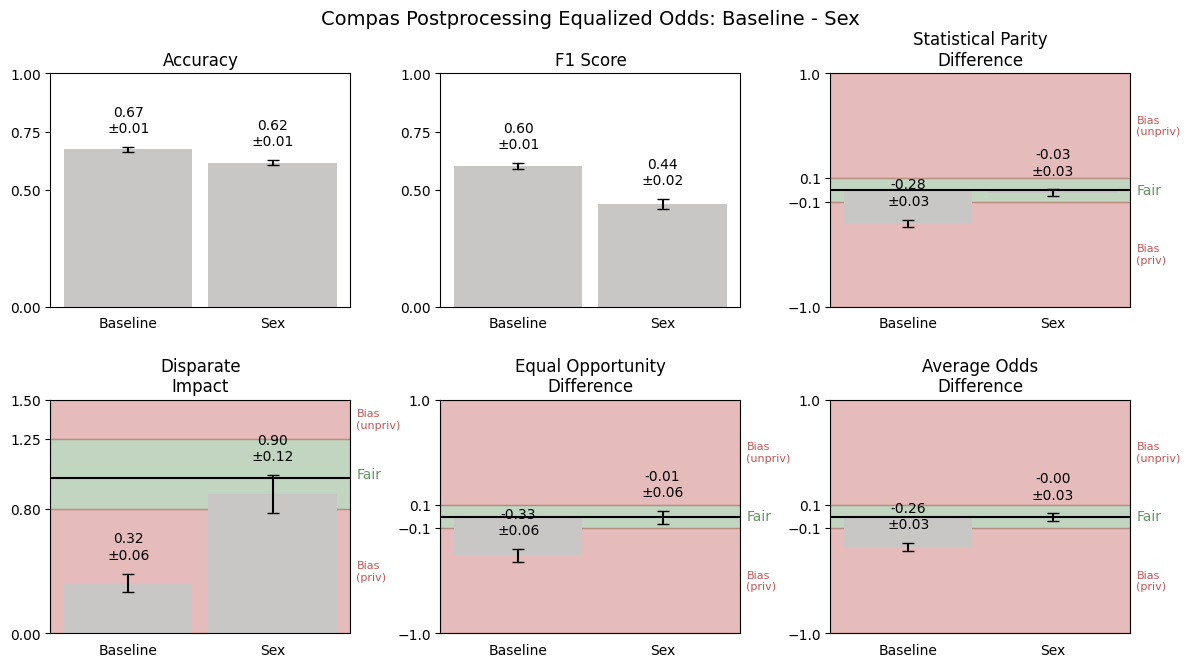

In [6]:
plot_title = 'Compas Postprocessing Equalized Odds: Baseline - Sex'
fig = compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Sex', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

## default eq odds, race

In [7]:
# 1) Load data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = eq_odds_postprocessing_train_and_predict(
        df,
        train_idx,
        test_idx,
        protected,
        privileged_value,
        unprivileged_value)
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.638281  0.511158 -0.027432  0.910537 -0.008322 -0.006698
std   0.011349  0.014343  0.025028  0.084050  0.039644  0.024586


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_43669/3759757192.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


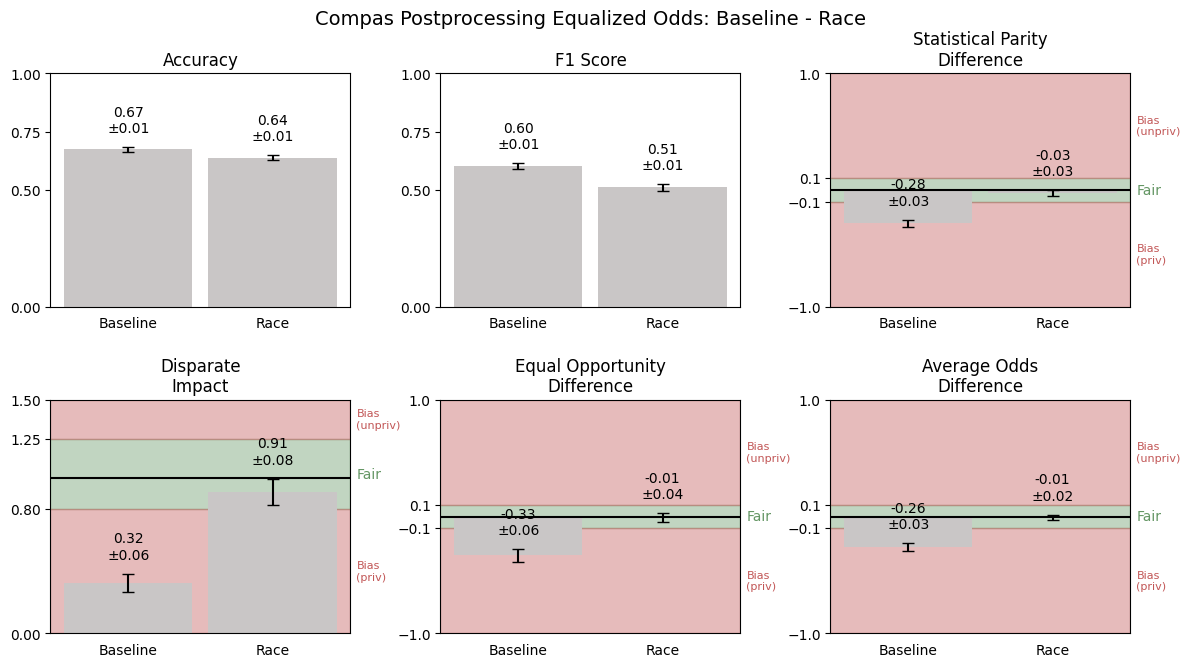

In [8]:
plot_title = 'Compas Postprocessing Equalized Odds: Baseline - Race'
fig = compare_viz_metrics_2x3(baseline_sex_agg, compas_race_metrics_agg, 'Baseline', 'Race', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

In [9]:
# 1) Save the aggregated metrics 
save_agg_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_agg_df       = compas_race_metrics_agg,
    sex_agg_df        = compas_sex_metrics_agg,
    pipeline_stage    = pipeline_stage   
)

# 2) Save the raw metrics
save_raw_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_raw_df       = compas_race_metrics,
    sex_raw_df        = compas_sex_metrics,
    pipeline_stage    = pipeline_stage
)